In [4]:
from os import listdir, getcwd, rename, makedirs, remove, walk
from os.path import isfile, join, isdir, exists
from owlready2 import *
import json
import rdflib
import requests
import pandas as pd
import logging, itertools
from tqdm import tqdm
import matplotlib.pyplot as plt

log = logging.getLogger(__name__)
logging.basicConfig(filename='patient_treatment_type.log', level=logging.INFO, format='%(levelname)s:%(asctime)s: %(message)s', datefmt='%d/%m/%Y %I:%M %p')

/Users/tushar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Common functions

In [5]:
def get_dirs(path):
    return [f for f in listdir(path) if isdir(join(path, f))]


def get_files(path):
    return [join(path, f) for f in listdir(path) if isfile(join(path, f)) and f.endswith(".tsv")]


def read_metadata_without_fields(path):
    metadata = pd.read_csv(path, sep='\t', na_values="", low_memory=False)
    if 'Field' in metadata.columns:
        metadata = metadata.loc[metadata.Field.str.startswith('#') != True,].reset_index(drop=True)
        metadata = metadata.drop('Field', axis=1)
    return metadata


def read_metadata_with_fields(path):
    metadata = pd.read_csv(path, sep='\t', na_values="", low_memory=False)
    return metadata


def sort_case_insensitive(sort_list):
    return sorted(sort_list, key=str.casefold)


start_dir = getcwd()
home = "/Users/tushar/CancerModels/pdxfinder-data/data/UPDOG/"
# out_path = "/Users/tushar/CancerModels/pdxfinder-data/data/UPDOG/"
providers = sorted(get_dirs(home))


In [6]:
mappings = pd.read_json("/Users/tushar/CancerModels/pdxfinder-data/mapping/treatment_mappings.json")
mappings = pd.concat([mappings, mappings['mappingValues'].apply(pd.Series)], axis=1)
#onto = World()
#onto.get_ontology("file://ncit.owl").load() #path to the owl file is given here
#graph = onto.as_rdflib_graph()

In [7]:
treatment = pd.DataFrame()
for root, dirs, files in walk(home):
    for file in files:
        if file.endswith("treatment-Sheet1.tsv"):
             data = pd.read_csv(join(root, file),sep='\t')
             if 'Field' in data.columns:
                 data = data.loc[data['Field'].astype(str).str.startswith('#') != True,].reset_index(drop=True)
                 data = data.drop('Field', axis=1)
             data['provider'] = file.replace('_patienttreatment-Sheet1.tsv','')
             treatment = pd.concat([treatment, data])
treatment = treatment.fillna('')
t_names = list(treatment.treatment_name.unique())
# Initialize an empty list to store individual drugs
individual_drugs = []

# Iterate through the elements in the drug_list
for element in t_names:
    # Split the element using "+" as the separator
    element = element.replace(" + ", "+")
    drugs = element.split("+")
    # Extend the individual_drugs list with the split drugs
    individual_drugs.extend(drugs)
individual_drugs = list(set(individual_drugs))

In [8]:
drugs = pd.DataFrame()
for root, dirs, files in walk(home):
    for file in files:
        if file.endswith("drugdosing-Sheet1.tsv"):
             data = pd.read_csv(join(root, file),sep='\t')
             if 'Field' in data.columns:
                 data = data.loc[data['Field'].astype(str).str.startswith('#') != True,].reset_index(drop=True)
                 data = data.drop('Field', axis=1)
             data['provider'] = file.replace('_drugdosing-Sheet1.tsv','')
             drugs = pd.concat([drugs, data])
drugs = drugs.fillna('')
t_names = list(drugs.treatment_name.unique())
# Initialize an empty list to store individual drugs
dosing_individual_drugs = []

# Iterate through the elements in the drug_list
for element in t_names:
    # Split the element using "+" as the separator
    element = element.replace(" + ", "+")
    drug = element.split("+")
    # Extend the individual_drugs list with the split drugs
    dosing_individual_drugs.extend(drug)
dosing_individual_drugs = list(set(dosing_individual_drugs))

In [10]:
set_a = set(dosing_individual_drugs)
set_b = set(individual_drugs)

result = list(set_a - set_b)
individual_drugs = individual_drugs + result

In [58]:
treatment = treatment.replace("", "Not provided")

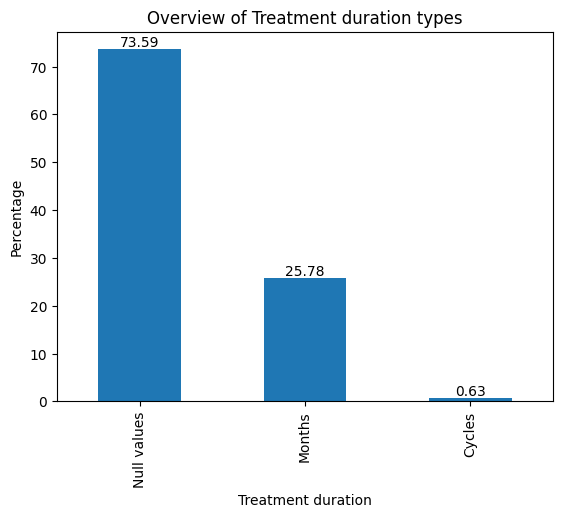

In [101]:
x = treatment['treatment_duration'].str.replace(".*cycle.*", "Cycles", regex=True).str.replace("\d.*", "Months", regex=True).str.replace("Not.*", "Null values", regex=True).replace("Ongoing", "Null values").value_counts()/len(treatment['treatment_duration'])*100
ax = x.plot(kind='bar')
# Add labels and title
plt.xlabel('Treatment duration')
plt.ylabel('Percentage')
plt.title('Overview of Treatment duration types')
# Show the counts on top of the bars
for i, count in enumerate(x):
    ax.text(i, count, str(round(count, 2)), ha='center', va='bottom')
# Show the plot
plt.show()

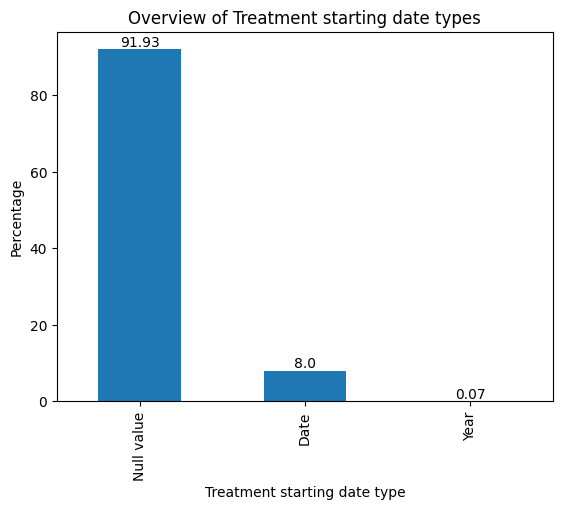

In [102]:
x = treatment['treatment_starting_date'].str.replace("\d*/\d*/\d*", "Date", regex=True).str.replace("\w*-\d*", "Date", regex=True).str.replace("\d+", "Year", regex=True).replace("Not provided", "Null value").value_counts()/len(treatment['treatment_starting_date'])*100
ax = x.plot(kind='bar')
# Add labels and title
plt.xlabel('Treatment starting date type')
plt.ylabel('Percentage')
plt.title('Overview of Treatment starting date types')
# Show the counts on top of the bars
for i, count in enumerate(x):
    ax.text(i, count, str(round(count, 2)), ha='center', va='bottom')
# Show the plot
plt.show()

In [93]:
treatment['treatment_starting_date'].value_counts()/len(treatment['treatment_starting_date'])*100

treatment_starting_date
Not provided    91.929382
May-15           0.126103
Mar-13           0.126103
01/12/2018       0.126103
Jun-16           0.108089
                  ...    
Mar-10           0.018015
Dec-19           0.018015
Dec-06           0.018015
Oct-05           0.018015
28/11/2012       0.018015
Name: count, Length: 242, dtype: float64

In [ ]:
no_duration_df = treatment[[True if len(td)>2 else False for td in list(treatment['treatment_duration'].replace('', 'Not provided'))]].replace('', 'Not provided').reset_index(drop=True)
no_duration_df

In [11]:
mappings = mappings[['TreatmentName', 'mappedTermUrl', 'mappedTermLabel']].drop_duplicates(subset=['TreatmentName']).reset_index(drop=True)
mapped = pd.DataFrame()
not_mapped = []
for drug in individual_drugs:
    temp = mappings[mappings['TreatmentName'] == drug]
    if len(temp)>0:
        mapped = pd.concat([mapped, temp])
    else:
        not_mapped.append(drug)
mapped = mapped.reset_index(drop=True)

In [ ]:
no_duration_df.treatment_name.unique()

In [12]:
def read_file_as_list(file_path):
    try:
        with open(file_path, "r") as file:
            # Read each line from the file and convert it to an integer, then append to the list
            my_list = [str(line.strip()) for line in file]
        return my_list
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

def read_file_as_dict(file_path):
    # Open the JSON file for reading
    try:
        with open(file_path, "r") as file:
            # Load the JSON data into a Python dictionary
            my_dict = json.load(file)
        return my_dict
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
    except json.JSONDecodeError as e:
        print(f"JSON decoding error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [21]:
class map_treatment_to_treatment_type:
    def __init__(self, drug_list, mapped, drug_map):
        self.label = ""
        self.drug = None
        self.data = list()
        self.treatment_type = "NA"
        self.mapped = mapped
        self.drug_list = drug_list
        self.map_d = drug_map
        self.drug_info = list()
        ## Keywords
        self.targeted, self.hormone, self.immune = read_file_as_list("targeted_keywords.txt"), read_file_as_list("hormone_keywords.txt"), read_file_as_list("immune_keywords.txt")
        self.radiation = read_file_as_list("radiation_keywords.txt")
        self.chemo = ["chemotherapy", "antineoplastic agent", "chemotherapeutic agent", "cytotoxic drug", "antineoplastic therapy", "chemo"]
    
        ## Drugs 
        self.drug_skip_list = read_file_as_list("skip_list.txt")
        ## Drug names
        self.surgery = ["Biopsy", "surgery", "Surgery", "Lymphadenectomy", "Mastectomy", "Mastectomy", "Vertebroplasty"]
        self.stem_trans = ["Autologous Hematopoietic Stem Cell Transplantation"]
        
        self.unkown = read_file_as_list("no_mapping.txt")
        self.immune_drug = read_file_as_list("immune_drug.txt")
        self.hormone_drugs = read_file_as_list("hormone_drug.txt")
        self.targeted_drugs = read_file_as_list("targeted_drug.txt")
        self.chemo_drugs = read_file_as_list("chemo_drug.txt")
    def get_drug_info(self):
        try:
            self.drug_info = list(default_world.sparql("SELECT ?class ?dn ?desc WHERE {?class rdf:type owl:Class . ?class rdfs:label '"+self.drug+"' ?class obo:NCIT_P302 ?desc . ?class obo:NCIT_P107 ?dn . } "))
        except:
            self.drug_info = []
        if len(self.drug_info)>1:
            temp_str = ""
            for s in self.drug_info:
                temp_str = temp_str + s[2]
            self.drug_info = [self.drug_info[0][0], self.drug_info[0][1], temp_str]
        elif len(self.drug_info) == 1:
            self.drug_info = self.drug_info[0]
        
    def fetch_drug_OLS(self):
        url = "https://www.ebi.ac.uk/ols/api/search?q="+self.drug+"&ontology=ncit"
        response = requests.get(url)
        response = response.json()
        if len(response['response']['docs'])>0:
            response = response['response']['docs'][0]
            try:
                description = response['description'][0] 
            except:
                description = ''
                log.info("No description: "+url+"\n\n")
            self.drug_info = [response['iri'], response['label'], description]
        else:
            log.info("Not found in OLS: "+url+"\n\n\n")
            self.drug_info = []

    def get_ontology_rdf(self, url):
        # You can now query the graph or extract information from it
        # For example, let's print all triples in the graph:
        treatment_type = "NA"
        ht, tt, it, ct, rt = "Hormone therapy", "Targeted therapy", "Immunotherapy", "Chemotherapy", "Radiation therapy"
        
        if self.drug in self.unkown or self.drug.lower() in self.unkown:
            treatment_type = "Not provided"
        elif self.drug.__contains__("Radiation") or self.drug in ["Brachytherapy"]:
            treatment_type = rt
        elif self.drug in self.hormone_drugs or self.drug.lower() in self.hormone_drugs or self.drug.capitalize() in self.hormone_drugs:
            treatment_type = ht
        elif self.drug in self.targeted_drugs or self.drug.lower() in self.targeted_drugs or self.drug.capitalize() in self.targeted_drugs:
            treatment_type = tt
        elif self.drug in self.chemo_drugs or self.drug.lower() in self.chemo_drugs or self.drug.capitalize() in self.chemo_drugs:
            treatment_type = ct
        elif self.drug in self.immune_drug or self.drug.lower() in self.immune_drug or self.drug.capitalize() in self.immune_drug:
            treatment_type = it
        elif self.drug in self.stem_trans:
            treatment_type = "Stem Cell or Bone Marrow Transplantation"
        elif self.drug in self.surgery:
            treatment_type = "Surgery"
           
        # url = 'http://purl.obolibrary.org/obo/NCIT_C138044'
        response = requests.get(url)
        # Create a new RDF Graph
        graph = rdflib.Graph()
        # Parse the RDF/XML data
        # Load RDF/XML data into the graph
        graph.parse(data=response.text, format="xml")  
        for subj, pred, obj in graph:
            #print(f"Subject: {subj}\nPredicate: {pred}\nObject: {obj}\n")
            if str(subj) == url and str(pred).__contains__("rdf-schema#label"):
                label = obj
                if treatment_type != "NA":
                    break            
            if treatment_type == "NA":
                obj = str(obj).lower()
                if obj in self.targeted or any([obj.__contains__(t) for t in self.targeted]):
                    treatment_type = tt
                elif obj in self.hormone or any([obj.__contains__(h) for h in self.hormone]) :
                    treatment_type = ht
                elif obj in self.immune or any([obj.__contains__(i) for i in self.immune]):
                    treatment_type = it
                elif obj=="chemotherapy_regimen_has_component" or obj in self.chemo:
                    treatment_type = ct
                elif obj in self.radiation or any([obj.__contains__(i) for i in self.radiation]):
                    treatment_type = rt
        
        if treatment_type == "NA":
            log.info('No treatment type found for: '+ self.drug + ' | URL: '+url + " | Label: "+ label)
        self.label = label
        self.treatment_type = treatment_type
        
    def get_treatment_type(self):
        onto_drug = str(self.drug_info[0])
        if onto_drug.__contains__("obo.NCIT"):
            onto_drug = onto_drug.replace("obo.", "obo/")
            onto_drug = "http://purl.obolibrary.org/"+onto_drug
        self.get_ontology_rdf(onto_drug)

    def fetch_drug_information(self):
        
        for i in tqdm(range(0, len(self.drug_list)), desc ="Collecting drug information: "): 
            self.drug = self.drug_list[i]
            self.label = ""
            mappedURL = self.mapped[self.mapped['TreatmentName']==self.drug.lower()]['mappedTermUrl'].reset_index(drop=True)
            if len(mappedURL) == 0 and self.drug not in self.drug_skip_list:
                if self.drug in self.map_d:
                    self.drug = self.map_d[self.drug]
                self.get_drug_info()
                if len(self.drug_info) == 0:
                    self.fetch_drug_OLS()
            else:
                if self.drug in self.drug_skip_list:
                    self.drug_info = []
                else:
                    self.drug_info = [mappedURL[0], self.drug, ""]
            if len(self.drug_info) > 0:
                self.get_treatment_type()
                self.drug_info.append(self.treatment_type)
                self.drug_info.append(self.label)
                self.drug_info.append(self.drug_list[i])
                self.data.append(self.drug_info)
            else:
                log.info("Skipped drug: "+self.drug)
                
    def generate_df(self):
        drug_info = pd.DataFrame(self.data, columns=['NCIT', 'treatment_name', 'description', 'treatment_type', 'drug_name', "NCIT_label"])
        drug_info.to_csv('/Users/tushar/CancerModels/treatment_type.tsv', sep='\t', index=False)
    
    def main(self):
        self.fetch_drug_information()
        self.generate_df()
    

In [22]:
drug_map = read_file_as_dict("drug_map.json")
get_treatment_type = map_treatment_to_treatment_type(sorted(individual_drugs), mapped, drug_map)
get_treatment_type.main()

# Add treatment type

In [24]:
treatment_mappings = pd.read_csv("/Users/tushar/CancerModels/treatment_type.tsv", sep='\t')

## Drug dosing

In [25]:
def map_treatment_to_type(row):
    drugs = row.replace(" + ", "+")
    drugs = drugs.split("+")
    treatment_type = ""
    for drug in drugs:
        tt = treatment_mappings[treatment_mappings["drug_name"]==drug]["treatment_type"].reset_index(drop=True)
        if len(tt)>1:
            tt = tt[0]
        if len(tt)>0:
            if len(tt)==1:
                tt = tt[0]
            treatment_type = treatment_type + "+" +tt
    if treatment_type == "":
        treatment_type = "Not provided"
    else:
        treatment_type = treatment_type[1:]
    treatment_list = treatment_type.split("+")
    all_same = all(element == treatment_list[0] for element in treatment_list)
    if all_same:
        return treatment_list[0]
    return treatment_type
    
#new_col = "treatment_type"
for root, dirs, files in walk(home):
    for file in files:
        if file.endswith("drugdosing-Sheet1.tsv"):
            data = pd.read_csv(join(root, file),sep='\t')
            columns = data.columns
            data["treatment_type"] = data['treatment_name'].apply(map_treatment_to_type)
            data = data[columns]
            data.to_csv(join(root, file),sep='\t', index=False)
            log.info("added treatment type to "+ file)


## Patient treatment

In [ ]:
def map_treatment_to_type(row):
    drugs = row.replace(" + ", "+")
    drugs = drugs.split("+")
    treatment_type = ""
    for drug in drugs:
        tt = treatment_mappings[treatment_mappings["NCIT_label"]==drug]["treatment_type"].reset_index(drop=True)
        if len(tt)>1:
            tt = tt[0]
        if len(tt)>0:
            if len(tt)==1:
                tt = tt[0]
            treatment_type = treatment_type + "+" +tt
    if treatment_type == "":
        treatment_type = "Not provided"
    else:
        treatment_type = treatment_type[1:]
    treatment_list = treatment_type.split("+")
    all_same = all(element == treatment_list[0] for element in treatment_list)
    if all_same:
        return treatment_list[0]
    return treatment_type
    
#new_col = "treatment_type"
for root, dirs, files in walk(home):
    for file in files:
        if file.endswith("treatment-Sheet1.tsv"):
            #try:
            data = pd.read_csv(join(root, file),sep='\t')
            columns = data.columns
            #columns = columns.insert(3, new_col)
            header = data[0:4]
            #header[new_col] = ["Treatment type categorised as Surgery, Radiation Therapy, Chemotherapy, Immunotherapy, Targeted Therapy, Hormone Therapy",
            #                   "Chemotherapy", "[Surgery, Radiation Therapy, Chemotherapy, Immunotherapy, Targeted Therapy, Hormone Therapy]", "essential"]
            data = data[4:]
            data["treatment_type"] = data['treatment_name'].apply(map_treatment_to_type)
            
            data = pd.concat([header, data]).reset_index(drop=True)
            data = data[columns]
            data.to_csv(join(root, file),sep='\t', index=False)
            log.info("added treatment type to "+ file)
            #except Exception as e:
            #    print(f"Error processing {file}: {str(e)}")

In [ ]:
def map_treatment_to_NCIT(row):
    drugs = row.replace(" + ", "+")
    drugs = drugs.split("+")
    d = ""
    if row.__contains__("FEC ("):
        d = "FEC regimen"
    else:
        for drug in drugs:
            tt = treatment_mappings[treatment_mappings["drug_name"]==drug]["NCIT_label"].reset_index(drop=True)
            if len(tt)>1:
                tt = tt[0]
            if len(tt)>0:
                tt = tt[0]
            else:
                tt = drug        
            d = d + "+" +tt  
        d = d[1:]
    log.info("Remapped: "+row+" to "+ d)
    return d
    
for root, dirs, files in walk(home):
    for file in files:
        if file.endswith("treatment-Sheet1.tsv"):
            log.info("added treatment type to "+ file)
            data = pd.read_csv(join(root, file),sep='\t')
            header = data[0:4]
            data = data[4:]
            data["treatment_name"] = data['treatment_name'].apply(map_treatment_to_NCIT)            
            data = pd.concat([header, data]).reset_index(drop=True)
            data.to_csv(join(root, file),sep='\t', index=False)
            

# Rename treaments/Mapping treatments
- Curie-BC:
    - rename EC100 to FEC100
    - 3FUN
    - 3TAC
- CRL:
    - rename leuvocorin to Leucovorin 

treatment[treatment['treatment_name'].str.contains('Surgery')]

list(onto.world.sparql("""

SELECT ?class ?dn
WHERE {
    ?class rdf:type owl:Class . 
    ?class rdfs:label ?label .
    ?class obo:NCIT_P302 ?desc . 
    ?class obo:NCIT_P107 ?dn .
    FILTER (regex(str(?label), "regimen", "i"))
    OPTIONAL {}

    } 
"""
))
"""
SELECT ?class ?description
WHERE {
  ?class rdf:type owl:Class ;
         rdfs:label "Dasatinib" .
  OPTIONAL {
    ?class oboInOwl:hasExactSynonym ?synonym .
    FILTER(STR(?synonym) CONTAINS "Dasatinib")
  }
  OPTIONAL {
    ?class obo:NCIT_P302 ?description .
  }
}
"""
list(default_world.sparql("SELECT ?class ?desc ?dn WHERE {?class rdf:type owl:Class . ?class rdfs:label 'Etoposide' ?class obo:NCIT_P107 'Etoposide'  ?class obo:NCIT_P302 ?desc . ?class obo:NCIT_P107 ?dn . } "))
list(default_world.sparql(
    "SELECT ?class ?dn  ?desc WHERE {?class rdf:type owl:Class ?class owl:Class obo:NCIT_C138044 ?class obo:NCIT_P302 ?desc . ?class obo:NCIT_P107 ?dn . }"))
list(default_world.sparql("""
            SELECT ?class ?onProperty
            WHERE {
              ?class rdfs:subClassOf [
                rdf:type owl:Restriction ;
                owl:onProperty ?onProperty ;
                owl:someValuesFrom obo:NCIT_C2152
              ] .
            }
    """))
list(default_world.sparql("""
            SELECT ?class ?onProperty
            WHERE {
              ?class rdfs:subClassOf [
                rdf:type owl:Restriction ;
                owl:onProperty ?onProperty ;
                owl:someValuesFrom obo:NCIT_C38713
              ] .
            }
    """))


import requests

# Define a list of drug names
drugs = list(treatment.treatment_name.unique())

# Define a function to query NCIT and get drug information
def get_drug_info(drug_name):
    base_url = "https://ncit.nci.nih.gov/ncitbrowser/api/ncitbrowser/vocabulary/term"
    params = {
        "type": "properties",
        "format": "json",
        "name": drug_name
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        return None

# Define a function to check if a drug is a chemotherapy drug based on NCIT
def is_chemotherapy_drug(drug_info):
    if drug_info and 'properties' in drug_info:
        for prop in drug_info['properties']:
            if 'label' in prop and prop['label'] == "Chemotherapy Regimen Component":
                return True
    return False

# Iterate through the list of drugs and fetch drug information
for drug in drugs:
    drug_info = get_drug_info(drug)
    if drug_info:
        is_chemo = is_chemotherapy_drug(drug_info)
        if is_chemo:
            print(f"{drug} is a chemotherapy drug.")
        else:
            print(f"{drug} is not a chemotherapy drug.")
    else:
        print(f"Information not found for {drug}.")

